In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import tqdm
import pickle
warnings.filterwarnings("ignore")

In [2]:
SEED = 1337
np.random.seed(SEED)

In [10]:
SPLIT_DATE_TRAIN = "2020-01-01"
RADIUS = 300
THRESHOLD = 150 
BLOCK_SIZE = 4

In [4]:
df = pd.read_csv("../data/with_features_final.csv")
df.dropna(inplace=True)

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [12]:
def filter_regions(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
    df_agg = df_f.groupby(["pos"]).agg({"mag": "count"}).reset_index()
    regions = df_agg.loc[df_agg["mag"] >= threshold, "pos"].values
    return regions

In [13]:
def make_block(df, pos, radius, block_size):
    lat, lon = pos.split("_")
    lat, lon = float(lat), float(lon)
    tmp1 = df[df["pos"] == pos]
    diff = int(radius / 111) + 3
    tmp2 = df[((df["latitude"] >= lat - diff) & (df["latitude"] <= lat + diff) & (df["longitude"] >= lon - diff) & (df["longitude"] <= lon + diff)) & (df["pos"] != pos)]
    tmp2["label"] = -1
    tmp = pd.concat([tmp1, tmp2], axis=0)
    tmp["distance"] = haversine_distance(tmp["latitude"], tmp["longitude"], lat + 0.5, lon + 0.5)
    tmp = tmp[tmp["distance"] <= radius]
    tmp.sort_values(by=["time"], inplace=True)
    tmp["diff_days"] = (tmp["time"] - tmp["time"].shift(1)).dt.days
    for idx in range(1, block_size):
        tmp["mag_" + str(idx)] = tmp["mag"].shift(idx)
        tmp["depth_" + str(idx)] = tmp["depth"].shift(idx)
        tmp["latitude_" + str(idx)] = tmp["latitude"].shift(idx)
        tmp["longitude_" + str(idx)] = tmp["longitude"].shift(idx)
        tmp["dist_" + str(idx)] = tmp["dist"].shift(idx)
        tmp["distance_" + str(idx)] = tmp["distance"].shift(idx)
        tmp["plate_" + str(idx)] = tmp["plate"].shift(idx)
        tmp["diff_days_" + str(idx)] = tmp["diff_days"].shift(idx)
    tmp = tmp[tmp["label"] != -1]
    tmp.dropna(inplace=True)
    return tmp

In [14]:
def make_npys(df, radius, th, block_size):
    df["time"] = pd.to_datetime(df["time"], format="mixed")
    df.sort_values(by="time", inplace=True)
    regions = filter_regions(df, th)
    df_final = pd.DataFrame()
    for pos in tqdm.tqdm(regions):
        df_pos = make_block(df, pos, radius, block_size)
        df_final = pd.concat([df_final, df_pos], axis=0)
    return df_final

In [15]:
tmp = make_npys(df, RADIUS, THRESHOLD, BLOCK_SIZE)

100%|██████████| 1378/1378 [14:25<00:00,  1.59it/s]


In [16]:
tmp

,time,longitude,latitude,depth,mag,longitude_disc,latitude_disc,pos,lat_cent,lon_cent,...,plate_2,diff_days_2,mag_3,depth_3,latitude_3,longitude_3,dist_3,distance_3,plate_3,diff_days_3
3272343,1974-09-04,107.5700,-9.0340,69.0,5.4,107,-10,-10_107,-9.5,107.5,...,7.0,13.0,4.6,89.00,-7.3250,106.8680,226.896080,251.641020,7.0,39.0
3272344,1977-08-28,107.5430,-9.7050,33.0,4.4,107,-10,-10_107,-9.5,107.5,...,7.0,2.0,5.2,113.00,-7.7750,109.1980,282.499732,267.644288,7.0,5.0
3272345,1981-02-24,107.4750,-9.2580,33.0,3.9,107,-10,-10_107,-9.5,107.5,...,7.0,86.0,4.9,33.00,-8.2860,108.7010,213.626164,188.758711,7.0,27.0
3272346,1981-03-02,107.7460,-9.4560,33.0,5.1,107,-10,-10_107,-9.5,107.5,...,7.0,8.0,4.9,33.00,-8.7290,106.1980,57.414580,166.684068,7.0,86.0
3272347,1981-09-10,107.7660,-9.6890,33.0,4.3,107,-10,-10_107,-9.5,107.5,...,7.0,19.0,5.7,33.00,-10.6810,107.9650,70.870604,140.842346,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067656,2023-08-18,93.9692,9.1561,10.0,4.7,93,9,9_93,9.5,93.5,...,11.0,1.0,4.3,96.53,7.3563,94.7353,29.142267,274.371027,11.0,3.0
3067659,2023-08-23,93.8846,9.1639,10.0,4.2,93,9,9_93,9.5,93.5,...,11.0,0.0,4.7,10.00,9.5714,93.9359,34.712301,48.454984,11.0,1.0
3067660,2023-08-23,93.8083,9.0904,10.0,4.4,93,9,9_93,9.5,93.5,...,11.0,0.0,4.6,10.00,9.0272,93.9337,5.815454,70.917624,11.0,0.0
3067661,2023-09-01,93.8627,9.4069,10.0,4.2,93,9,9_93,9.5,93.5,...,11.0,0.0,4.2,10.00,9.1639,93.8846,19.584596,56.369421,11.0,5.0


In [17]:
# tmp.to_csv("../data/feature_distribution.csv", index=False)

In [18]:
# tmp = pd.read_csv("../data/feature_distribution.csv")

In [37]:
tmp = tmp[tmp["time"] < SPLIT_DATE_TRAIN]

<Axes: >

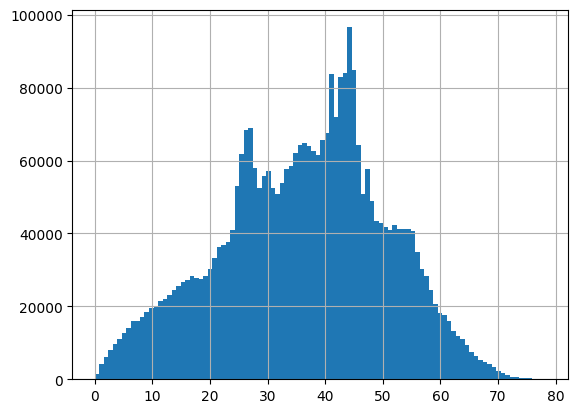

In [38]:
tmp["distance"].hist(bins=100)

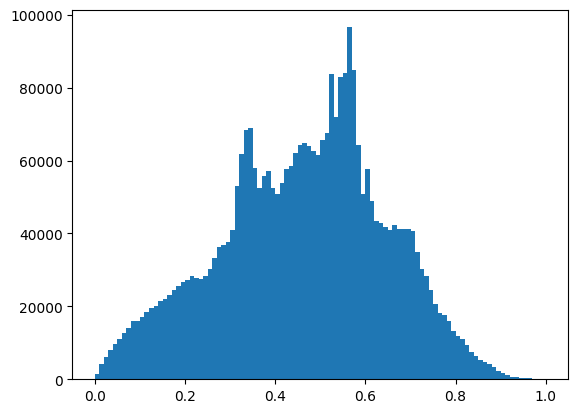

In [39]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["distance"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

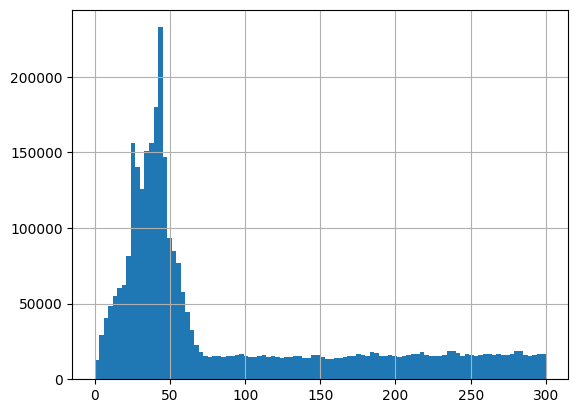

In [40]:
tmp["distance_1"].hist(bins=100)

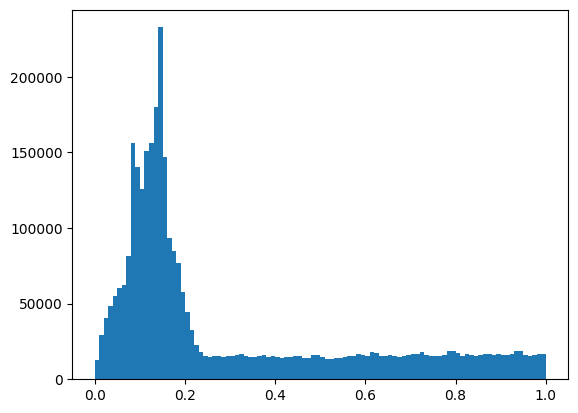

In [41]:
d = scaler.fit_transform(tmp["distance_1"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

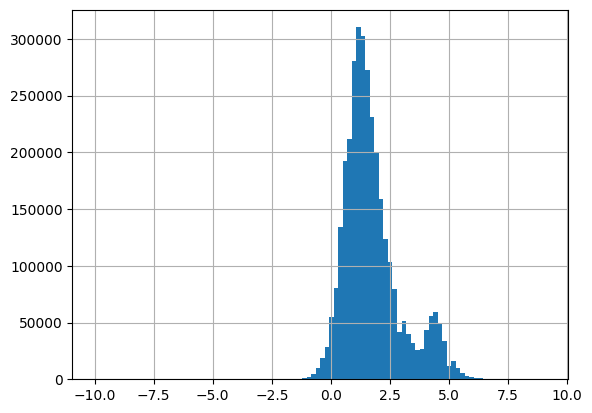

In [42]:
tmp["mag"].hist(bins=100)

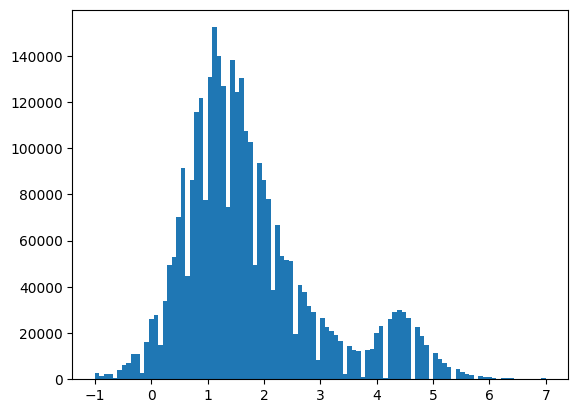

In [43]:
d = np.clip(tmp["mag"].values, -1, 7)
plt.hist(d, bins=100)
plt.show()

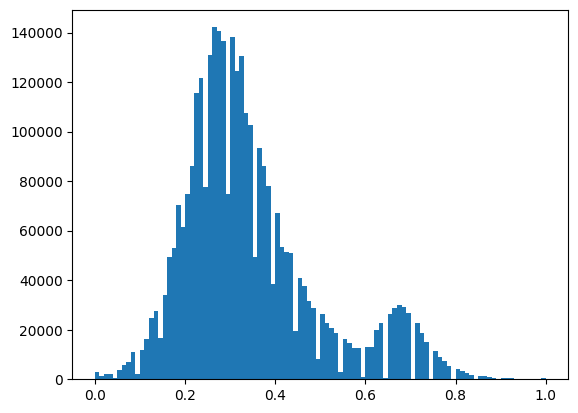

In [44]:
sclaer = MinMaxScaler()
d = sclaer.fit_transform(d.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

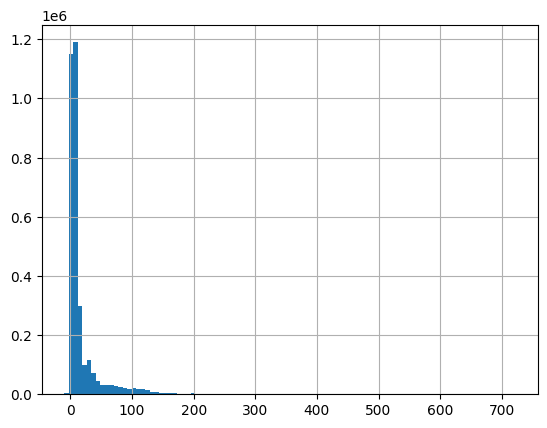

In [45]:
tmp["depth"].hist(bins=100)

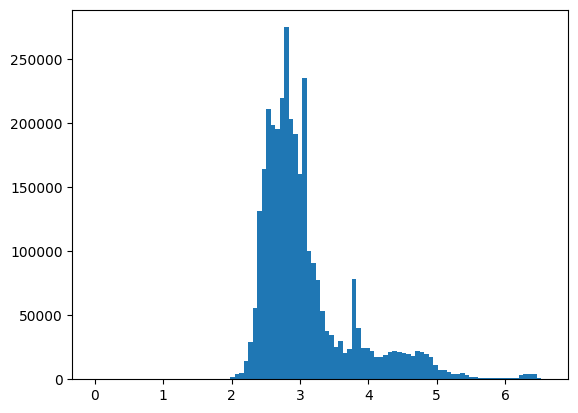

In [46]:
d = np.log(tmp["depth"] + np.abs(tmp["depth"].min()) + 1)
plt.hist(d, bins=100)
plt.show()

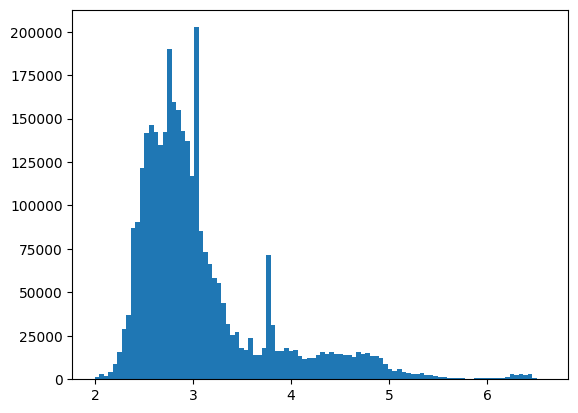

In [47]:
d = np.clip(d, 2, 10)
plt.hist(d, bins=100)
plt.show()

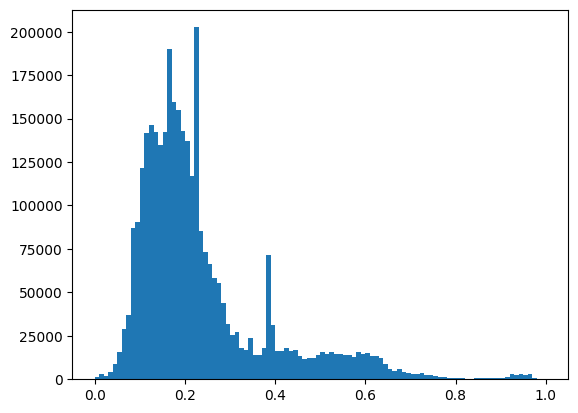

In [48]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

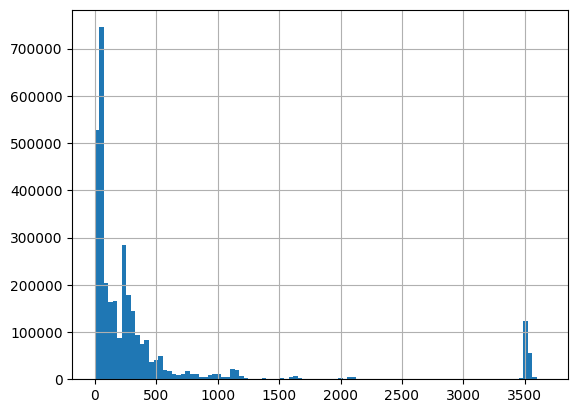

In [49]:
tmp["dist"].hist(bins=100)

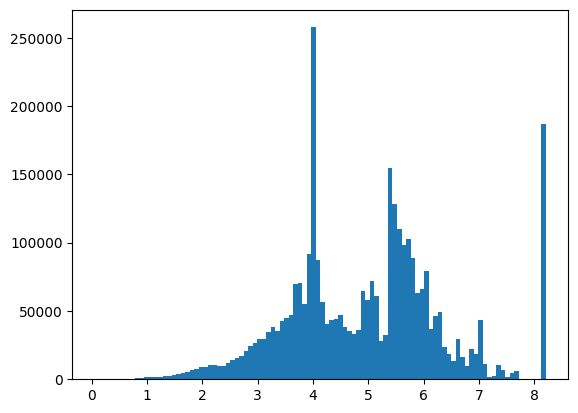

In [50]:
d = np.log(tmp["dist"]+1)
plt.hist(d, bins=100)
plt.show()

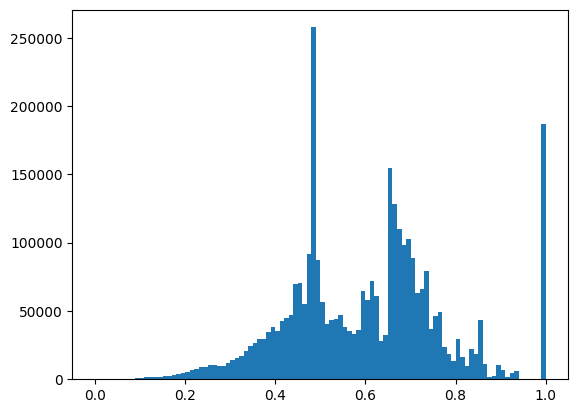

In [51]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

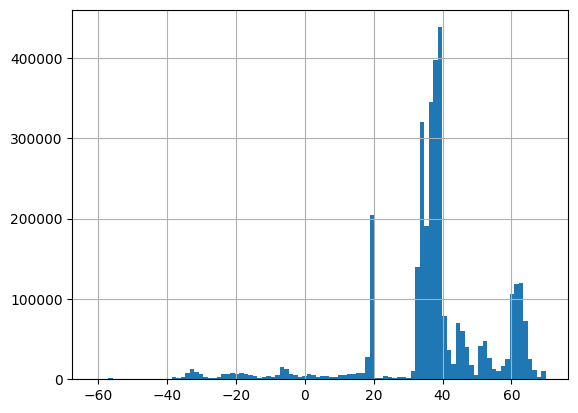

In [52]:
tmp["latitude"].hist(bins=100)

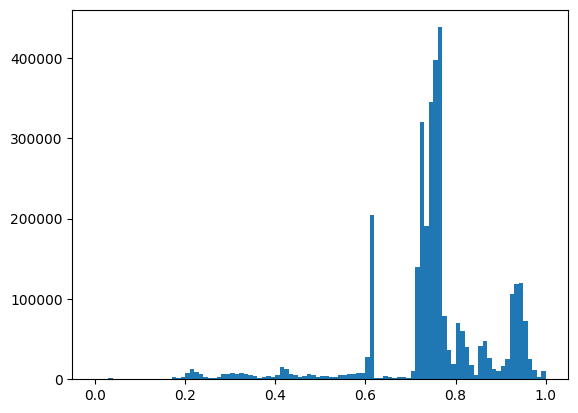

In [53]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["latitude"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

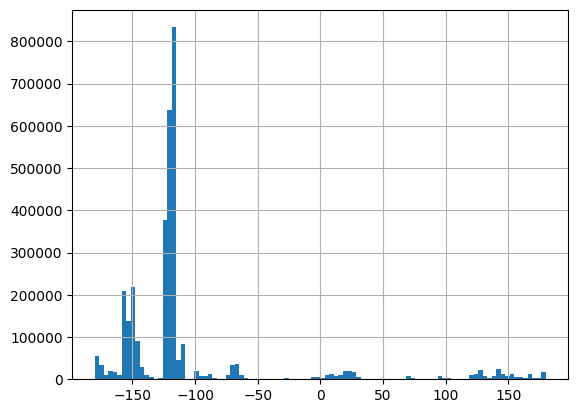

In [54]:
tmp["longitude"].hist(bins=100)

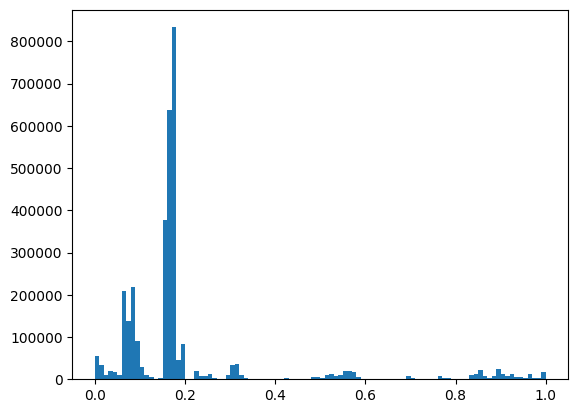

In [55]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["longitude"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()